# House Price Prediction using PyTorch Neural Network

## Introduction

This notebook demonstrates how to build a neural network from scratch using **PyTorch** to predict house prices based on three key features:
- **House Size** (square feet)
- **Number of Bedrooms**
- **House Age** (years)

### Learning Objectives

1. Understand the mathematical foundations of neural networks
2. Learn forward propagation with detailed formulas
3. Dive deep into backpropagation and the chain rule
4. Implement a regression neural network in PyTorch
5. Train, evaluate, and visualize model performance

### What Makes This Tutorial Unique

We will not just implement code - we will explain **every mathematical operation** happening inside the neural network, including:
- How data normalization works mathematically
- The forward pass through each layer
- How gradients are calculated using the chain rule
- How the network learns through backpropagation


## Package Installation

Run this cell first to install all required packages:


In [52]:
%pip install torch numpy pandas matplotlib scikit-learn


Looking in indexes: https://artifactory.playticorp.com/artifactory/api/pypi/pypi.org/simple
Note: you may need to restart the kernel to use updated packages.


## Setup and Imports

First, let's import all necessary libraries and set random seeds for reproducibility.


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cpu
PyTorch version: 2.9.1


## Dataset Creation

We'll create a synthetic dataset to have full control over the relationship between features and price. This helps us verify that our neural network can learn the underlying pattern.

### Features:
1. **House Size** (sq ft): 800 - 4000
2. **Number of Bedrooms**: 1 - 5
3. **House Age** (years): 0 - 50

### Price Formula:
We'll use a realistic pricing formula with some random noise:

$$
\text{Price} = 100 \times \text{Size} + 20000 \times \text{Bedrooms} - 2000 \times \text{Age} + \epsilon
$$

where $\epsilon \sim \mathcal{N}(0, 50000)$ represents market variability and other unmeasured factors.


In [54]:
# Generate synthetic house price dataset
n_samples = 1000

# Generate features
house_size = np.random.uniform(800, 4000, n_samples)  # Square feet
bedrooms = np.random.randint(1, 6, n_samples)  # 1-5 bedrooms
house_age = np.random.uniform(0, 50, n_samples)  # 0-50 years

# Generate prices using a realistic formula + noise
# Price = 100 * size + 20000 * bedrooms - 2000 * age + noise
base_price = 100 * house_size + 20000 * bedrooms - 2000 * house_age
noise = np.random.normal(0, 50000, n_samples)
price = base_price + noise

# Create DataFrame
data = pd.DataFrame({
    'Size (sq ft)': house_size,
    'Bedrooms': bedrooms,
    'Age (years)': house_age,
    'Price ($)': price
})

print("Dataset shape:", data.shape)
print("\nFirst few samples:")
print(data.head())
print("\nDataset statistics:")
print(data.describe())


Dataset shape: (1000, 4)

First few samples:
   Size (sq ft)  Bedrooms  Age (years)      Price ($)
0   1998.528380         4    24.772605  111524.327130
1   3842.285781         3    19.317445  435506.155798
2   3142.380614         5    22.506222  331141.207826
3   2715.707149         1    11.348235  284368.109736
4   1299.259649         5    44.469546  139515.136783

Dataset statistics:
       Size (sq ft)     Bedrooms  Age (years)      Price ($)
count   1000.000000  1000.000000  1000.000000    1000.000000
mean    2368.820971     3.038000    25.205232  248599.542417
std      934.839558     1.431295    14.632200  113921.024654
min      814.822474     1.000000     0.009420  -31094.073729
25%     1555.114456     2.000000    12.075613  161279.410643
50%     2389.783605     3.000000    26.080307  250440.341287
75%     3181.822682     4.000000    37.702210  327230.662475
max     3999.096555     5.000000    49.985690  564582.625593


## Data Normalization - The Mathematics

Before feeding data into a neural network, we must normalize it. This is crucial because:
1. Features have different scales (size: 800-4000, bedrooms: 1-5)
2. Large values can cause numerical instability
3. Normalization helps gradient descent converge faster

### Standard Normalization Formula (Z-score normalization)

For each feature $x$, we compute:

$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

where:
- $\mu = \frac{1}{n}\sum_{i=1}^{n} x_i$ is the **mean** of the feature
- $\sigma = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2}$ is the **standard deviation**

This transformation ensures:
- Mean of normalized data = 0
- Standard deviation of normalized data = 1
- The data follows an approximate standard normal distribution

**Why is this important?** Neural networks with normalized inputs converge faster because all features contribute equally to the learning process, and gradients remain in a reasonable range.


In [55]:
# Separate features and target
X = data[['Size (sq ft)', 'Bedrooms', 'Age (years)']].values
y = data['Price ($)'].values.reshape(-1, 1)

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Normalize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Show normalization effect
print("\n--- Before Normalization ---")
print(f"X_train mean: {X_train.mean(axis=0)}")
print(f"X_train std: {X_train.std(axis=0)}")

print("\n--- After Normalization ---")
print(f"X_train_scaled mean: {X_train_scaled.mean(axis=0)}")
print(f"X_train_scaled std: {X_train_scaled.std(axis=0)}")


Training samples: 800
Test samples: 200

--- Before Normalization ---
X_train mean: [2385.01203151    3.055        25.56341721]
X_train std: [936.32014206   1.42985139  14.50567581]

--- After Normalization ---
X_train_scaled mean: [ 3.73728826e-16 -4.82947016e-17 -3.79904441e-16]
X_train_scaled std: [1. 1. 1.]


In [56]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print("PyTorch tensors created!")
print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")


PyTorch tensors created!
X_train shape: torch.Size([800, 3])
y_train shape: torch.Size([800, 1])


---

# Mathematical Foundation of Neural Networks

Now that we have our data ready, let's understand the mathematics behind neural networks. We'll break this into two parts:
1. **Forward Propagation** - How the network makes predictions
2. **Backpropagation** - How the network learns from errors


## Part 1: Forward Propagation

Forward propagation is the process of computing the output of a neural network given an input. Let's build this step by step.

### 1.1 Linear Transformation (Dense Layer)

Each layer in a neural network performs a **linear transformation** followed by a **non-linear activation**. The linear transformation is:

$$
z = Wx + b
$$

where:
- $x \in \mathbb{R}^{m}$ is the input vector (m features)
- $W \in \mathbb{R}^{n \times m}$ is the weight matrix (n neurons in current layer, m from previous)
- $b \in \mathbb{R}^{n}$ is the bias vector (one bias per neuron)
- $z \in \mathbb{R}^{n}$ is the pre-activation output

**Intuition:** Each neuron computes a weighted sum of its inputs plus a bias term. The weights determine how much each input contributes to the neuron's output.

### 1.2 ReLU Activation Function

After the linear transformation, we apply a non-linear activation function. We use **ReLU** (Rectified Linear Unit):

$$
\text{ReLU}(z) = \max(0, z) = \begin{cases} 
z & \text{if } z > 0 \\
0 & \text{if } z \leq 0
\end{cases}
$$

**Why ReLU?**
- Introduces non-linearity (allows the network to learn complex patterns)
- Computationally efficient
- Helps avoid vanishing gradient problem
- Biologically inspired (similar to neuron activation)

### 1.3 Complete Forward Pass Through Our Network

Our network architecture is:
- **Input Layer:** 3 features (size, bedrooms, age)
- **Hidden Layer 1:** 64 neurons with ReLU
- **Hidden Layer 2:** 32 neurons with ReLU  
- **Output Layer:** 1 neuron (predicted price)

The complete forward pass:

$$
\begin{align}
z^{[1]} &= W^{[1]} x + b^{[1]} \quad &\text{(Linear: } \mathbb{R}^3 \rightarrow \mathbb{R}^{64}\text{)} \\
a^{[1]} &= \text{ReLU}(z^{[1]}) \quad &\text{(Activation)} \\
z^{[2]} &= W^{[2]} a^{[1]} + b^{[2]} \quad &\text{(Linear: } \mathbb{R}^{64} \rightarrow \mathbb{R}^{32}\text{)} \\
a^{[2]} &= \text{ReLU}(z^{[2]}) \quad &\text{(Activation)} \\
z^{[3]} &= W^{[3]} a^{[2]} + b^{[3]} \quad &\text{(Linear: } \mathbb{R}^{32} \rightarrow \mathbb{R}^{1}\text{)} \\
\hat{y} &= z^{[3]} \quad &\text{(Output - no activation for regression)}
\end{align}
$$

**In compact form:**

$$
\hat{y} = W^{[3]} \cdot \text{ReLU}\left(W^{[2]} \cdot \text{ReLU}\left(W^{[1]} x + b^{[1]}\right) + b^{[2]}\right) + b^{[3]}
$$

### 1.4 Loss Function: Mean Squared Error (MSE)

To train the network, we need to measure how wrong our predictions are. For regression, we use **Mean Squared Error**:

$$
\mathcal{L}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

where:
- $y_i$ is the true price for sample $i$
- $\hat{y}_i$ is the predicted price for sample $i$
- $n$ is the number of samples in the batch

**Intuition:** MSE penalizes large errors more than small ones (due to squaring). The goal of training is to minimize this loss.


## Part 2: Backpropagation - The Learning Algorithm

Backpropagation is how neural networks learn. It computes how much each weight and bias contributed to the error, then updates them to reduce the error. This is done using **calculus** (specifically, the chain rule).

### 2.1 The Chain Rule

The chain rule is the foundation of backpropagation. If we have a composite function $f(g(x))$, the derivative is:

$$
\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}
$$

**In neural networks:** We want to know how changing a weight $w$ affects the loss $\mathcal{L}$, so we need $\frac{\partial \mathcal{L}}{\partial w}$. The signal flows through many layers, so we use the chain rule repeatedly.

### 2.2 Gradients - Output Layer

Let's compute gradients step by step, starting from the output and moving backward.

**Step 1: Gradient of Loss with respect to prediction**

$$
\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{\partial}{\partial \hat{y}} \left[ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \right] = \frac{2}{n}(\hat{y} - y)
$$

**Step 2: Gradient of Loss with respect to output layer weights**

Recall: $\hat{y} = z^{[3]} = W^{[3]} a^{[2]} + b^{[3]}$

Using the chain rule:

$$
\frac{\partial \mathcal{L}}{\partial W^{[3]}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial W^{[3]}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \cdot (a^{[2]})^T
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{[3]}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial b^{[3]}} = \frac{\partial \mathcal{L}}{\partial \hat{y}}
$$

### 2.3 Gradients - Hidden Layers

**Step 3: Gradient flowing back through ReLU**

The gradient of ReLU is:

$$
\frac{\partial \text{ReLU}(z)}{\partial z} = \begin{cases} 
1 & \text{if } z > 0 \\
0 & \text{if } z \leq 0
\end{cases}
$$

**Intuition:** If a neuron was activated (z > 0), the gradient flows through. If it was off (z ≤ 0), the gradient is blocked.

**Step 4: Gradient with respect to second hidden layer**

$$
\frac{\partial \mathcal{L}}{\partial z^{[3]}} = \frac{\partial \mathcal{L}}{\partial \hat{y}}
$$

$$
\frac{\partial \mathcal{L}}{\partial a^{[2]}} = \frac{\partial \mathcal{L}}{\partial z^{[3]}} \cdot (W^{[3]})^T
$$

$$
\frac{\partial \mathcal{L}}{\partial z^{[2]}} = \frac{\partial \mathcal{L}}{\partial a^{[2]}} \odot \frac{\partial \text{ReLU}(z^{[2]})}{\partial z^{[2]}}
$$

where $\odot$ denotes element-wise multiplication.

$$
\frac{\partial \mathcal{L}}{\partial W^{[2]}} = \frac{\partial \mathcal{L}}{\partial z^{[2]}} \cdot (a^{[1]})^T
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{[2]}} = \frac{\partial \mathcal{L}}{\partial z^{[2]}}
$$

**Step 5: Gradient with respect to first hidden layer**

$$
\frac{\partial \mathcal{L}}{\partial a^{[1]}} = \frac{\partial \mathcal{L}}{\partial z^{[2]}} \cdot (W^{[2]})^T
$$

$$
\frac{\partial \mathcal{L}}{\partial z^{[1]}} = \frac{\partial \mathcal{L}}{\partial a^{[1]}} \odot \frac{\partial \text{ReLU}(z^{[1]})}{\partial z^{[1]}}
$$

$$
\frac{\partial \mathcal{L}}{\partial W^{[1]}} = \frac{\partial \mathcal{L}}{\partial z^{[1]}} \cdot x^T
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{[1]}} = \frac{\partial \mathcal{L}}{\partial z^{[1]}}
$$

### 2.4 Gradient Descent Update Rule

Once we have all the gradients, we update the parameters using **gradient descent**:

$$
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
$$

where:
- $\theta$ represents all parameters (weights and biases)
- $\alpha$ is the **learning rate** (how big of a step to take)
- $\nabla_\theta \mathcal{L}$ is the gradient of the loss with respect to $\theta$

For each parameter:

$$
W^{[l]}_{t+1} = W^{[l]}_t - \alpha \frac{\partial \mathcal{L}}{\partial W^{[l]}}
$$

$$
b^{[l]}_{t+1} = b^{[l]}_t - \alpha \frac{\partial \mathcal{L}}{\partial b^{[l]}}
$$

**Intuition:** We move the parameters in the opposite direction of the gradient (downhill) to minimize the loss.

### 2.5 Summary of Backpropagation

1. **Forward pass:** Compute predictions and loss
2. **Backward pass:** Compute gradients using chain rule (output → input)
3. **Update:** Adjust weights and biases using gradient descent
4. **Repeat:** Until the loss converges

**The magic:** PyTorch does all these gradient calculations automatically with `loss.backward()`!


---

# Building the Neural Network in PyTorch

Now that we understand the mathematics, let's implement the neural network using PyTorch.


## Neural Network Architecture

We'll create a class that inherits from `nn.Module`, PyTorch's base class for all neural network modules.

**Architecture:**
- Input: 3 features (size, bedrooms, age)
- Hidden Layer 1: 64 neurons + ReLU activation
- Hidden Layer 2: 32 neurons + ReLU activation
- Output Layer: 1 neuron (predicted price, no activation)


In [57]:
class HousePriceNN(nn.Module):
    """
    Neural Network for House Price Prediction
    
    Architecture:
        Input(3) -> Dense(64, ReLU) -> Dense(32, ReLU) -> Dense(1)
    """
    
    def __init__(self, input_size=3, hidden1_size=64, hidden2_size=32, output_size=1):
        super(HousePriceNN, self).__init__()
        
        # Layer 1: Input -> Hidden1
        # Mathematical: z^[1] = W^[1] * x + b^[1]
        self.fc1 = nn.Linear(input_size, hidden1_size)
        
        # Layer 2: Hidden1 -> Hidden2
        # Mathematical: z^[2] = W^[2] * a^[1] + b^[2]
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        
        # Layer 3: Hidden2 -> Output
        # Mathematical: z^[3] = W^[3] * a^[2] + b^[3]
        self.fc3 = nn.Linear(hidden2_size, output_size)
        
        # ReLU activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, 3)
            
        Returns:
            predictions: Output tensor of shape (batch_size, 1)
        """
        # Layer 1: Linear + ReLU
        # z^[1] = W^[1] * x + b^[1]
        # a^[1] = ReLU(z^[1])
        x = self.fc1(x)
        x = self.relu(x)
        
        # Layer 2: Linear + ReLU
        # z^[2] = W^[2] * a^[1] + b^[2]
        # a^[2] = ReLU(z^[2])
        x = self.fc2(x)
        x = self.relu(x)
        
        # Layer 3: Linear (no activation for regression)
        # y_hat = W^[3] * a^[2] + b^[3]
        x = self.fc3(x)
        
        return x

# Create the model instance
model = HousePriceNN().to(device)

print("Model Architecture:")
print(model)
print("\n" + "="*50)


Model Architecture:
HousePriceNN(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)



### Model Parameters

Let's examine how many parameters our network has. Each parameter is a value that will be learned during training.


In [58]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Parameters Breakdown:")
print("="*50)

for name, param in model.named_parameters():
    print(f"{name:20s} | Shape: {str(list(param.shape)):20s} | Count: {param.numel()}")

print("="*50)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Mathematical calculation verification:
# Layer 1: (3 inputs × 64 neurons) + 64 biases = 192 + 64 = 256
# Layer 2: (64 × 32) + 32 biases = 2048 + 32 = 2080
# Layer 3: (32 × 1) + 1 bias = 32 + 1 = 33
# Total: 256 + 2080 + 33 = 2369

print("\nMathematical Verification:")
print(f"Layer 1: (3 × 64) + 64 = {3*64 + 64}")
print(f"Layer 2: (64 × 32) + 32 = {64*32 + 32}")
print(f"Layer 3: (32 × 1) + 1 = {32*1 + 1}")
print(f"Total: {3*64 + 64 + 64*32 + 32 + 32*1 + 1}")


Model Parameters Breakdown:
fc1.weight           | Shape: [64, 3]              | Count: 192
fc1.bias             | Shape: [64]                 | Count: 64
fc2.weight           | Shape: [32, 64]             | Count: 2048
fc2.bias             | Shape: [32]                 | Count: 32
fc3.weight           | Shape: [1, 32]              | Count: 32
fc3.bias             | Shape: [1]                  | Count: 1
Total parameters: 2,369
Trainable parameters: 2,369

Mathematical Verification:
Layer 1: (3 × 64) + 64 = 256
Layer 2: (64 × 32) + 32 = 2080
Layer 3: (32 × 1) + 1 = 33
Total: 2369


---

# Training the Neural Network

Now we'll train our network using the backpropagation algorithm we discussed earlier.


## Training Setup

We need to define:
1. **Loss Function:** Mean Squared Error (MSE) - measures prediction error
2. **Optimizer:** Adam - an advanced version of gradient descent with adaptive learning rates

**Adam Optimizer** improves upon basic gradient descent by:
- Adapting the learning rate for each parameter
- Using momentum (history of gradients)
- Generally converging faster than vanilla gradient descent


In [59]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error: L = (1/n) * Σ(y - ŷ)²
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate α = 0.001

# Training hyperparameters
num_epochs = 200
batch_size = 32

# Create data loaders for batching
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training Configuration:")
print(f"  Number of epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 0.001")
print(f"  Optimizer: Adam")
print(f"  Loss function: MSE")
print(f"  Number of batches per epoch: {len(train_loader)}")


Training Configuration:
  Number of epochs: 200
  Batch size: 32
  Learning rate: 0.001
  Optimizer: Adam
  Loss function: MSE
  Number of batches per epoch: 25


## Training Loop

The training loop implements the complete learning cycle:

1. **Forward Pass:** Compute predictions $\hat{y} = f(x; \theta)$
2. **Compute Loss:** Calculate $\mathcal{L} = \frac{1}{n}\sum(y - \hat{y})^2$
3. **Backward Pass:** Compute gradients $\nabla_\theta \mathcal{L}$ using backpropagation
4. **Update Parameters:** $\theta \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}$
5. **Repeat** for multiple epochs


In [60]:
# Training loop
train_losses = []
val_losses = []

print("Starting training...")
print("="*70)

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # 1. Forward pass: compute predictions
        #    ŷ = f(x; θ) where θ are all weights and biases
        predictions = model(batch_X)
        
        # 2. Compute loss: L = (1/n) * Σ(y - ŷ)²
        loss = criterion(predictions, batch_y)
        
        # 3. Backward pass: compute gradients ∇L
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients using backpropagation (chain rule!)
        
        # 4. Update parameters: θ ← θ - α∇L
        optimizer.step()  # Update weights using Adam optimizer
        
        epoch_train_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Don't compute gradients for validation
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)
        val_losses.append(val_loss.item())
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {val_loss.item():.6f}")

print("="*70)
print("Training completed!")


Starting training...
Epoch [ 20/200] | Train Loss: 0.199742 | Val Loss: 0.191431
Epoch [ 40/200] | Train Loss: 0.193182 | Val Loss: 0.197133
Epoch [ 60/200] | Train Loss: 0.190757 | Val Loss: 0.204079
Epoch [ 80/200] | Train Loss: 0.188400 | Val Loss: 0.204271
Epoch [100/200] | Train Loss: 0.186354 | Val Loss: 0.201173
Epoch [120/200] | Train Loss: 0.184964 | Val Loss: 0.203054
Epoch [140/200] | Train Loss: 0.185270 | Val Loss: 0.201183
Epoch [160/200] | Train Loss: 0.183693 | Val Loss: 0.209569
Epoch [180/200] | Train Loss: 0.182293 | Val Loss: 0.206217
Epoch [200/200] | Train Loss: 0.180630 | Val Loss: 0.207914
Training completed!


## Visualize Training Progress

Let's plot how the loss decreased during training. This shows our network learning over time.


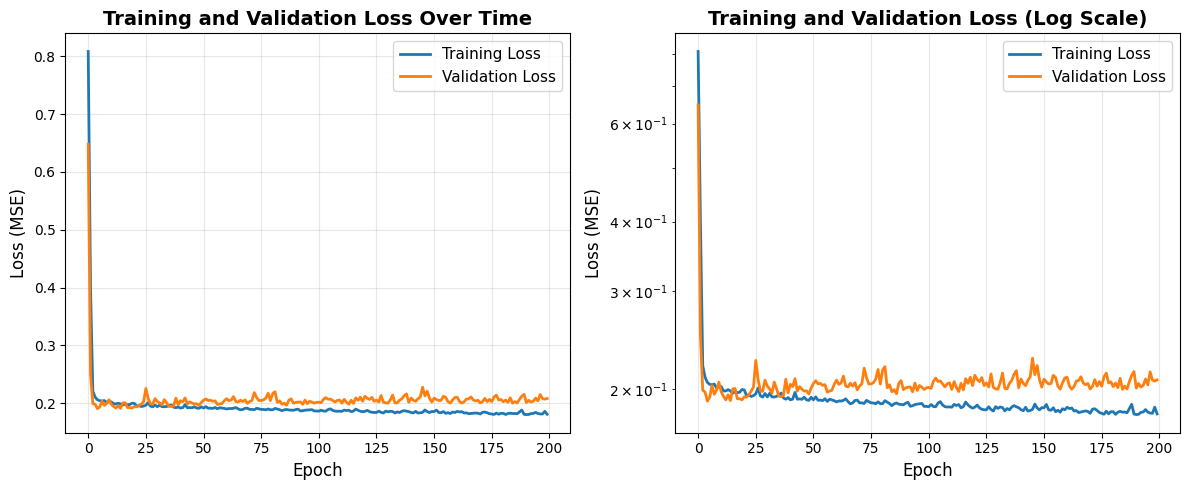

Final Training Loss: 0.180630
Final Validation Loss: 0.207914


In [61]:
plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot loss on log scale for better visibility
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")


---

# Model Evaluation

Now let's evaluate how well our trained model performs on the test set.


## Make Predictions on Test Set


In [62]:
# Make predictions on test set
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()

# Convert predictions back to original scale
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

print("Predictions generated!")
print(f"Predictions shape: {y_pred_original.shape}")
print(f"Test labels shape: {y_test_original.shape}")


Predictions generated!
Predictions shape: (200, 1)
Test labels shape: (200, 1)


## Evaluation Metrics

Let's compute standard regression metrics:

1. **Mean Squared Error (MSE):** $\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$
2. **Mean Absolute Error (MAE):** $\text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$
3. **R² Score (Coefficient of Determination):** $R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$

where:
- $y_i$ is the true value
- $\hat{y}_i$ is the predicted value
- $\bar{y}$ is the mean of true values
- $n$ is the number of samples

**R² Interpretation:**
- $R^2 = 1$: Perfect predictions
- $R^2 = 0$: Model is no better than predicting the mean
- $R^2 < 0$: Model is worse than predicting the mean


In [63]:
# Calculate metrics
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"Mean Squared Error (MSE):     ${mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Error (MAE):    ${mae:,.2f}")
print(f"R² Score:                     {r2:.4f}")
print("="*60)

# Interpret the results
print("\nInterpretation:")
print(f"- On average, predictions are off by ${mae:,.2f} (MAE)")
print(f"- The model explains {r2*100:.2f}% of variance in house prices (R²)")
if r2 > 0.9:
    print("- Excellent model performance!")
elif r2 > 0.7:
    print("- Good model performance")
else:
    print("- Model could be improved")


MODEL EVALUATION METRICS
Mean Squared Error (MSE):     $2,640,438,389.73
Root Mean Squared Error (RMSE): $51,385.20
Mean Absolute Error (MAE):    $41,298.19
R² Score:                     0.8118

Interpretation:
- On average, predictions are off by $41,298.19 (MAE)
- The model explains 81.18% of variance in house prices (R²)
- Good model performance


## Visualize Predictions vs Actual Values


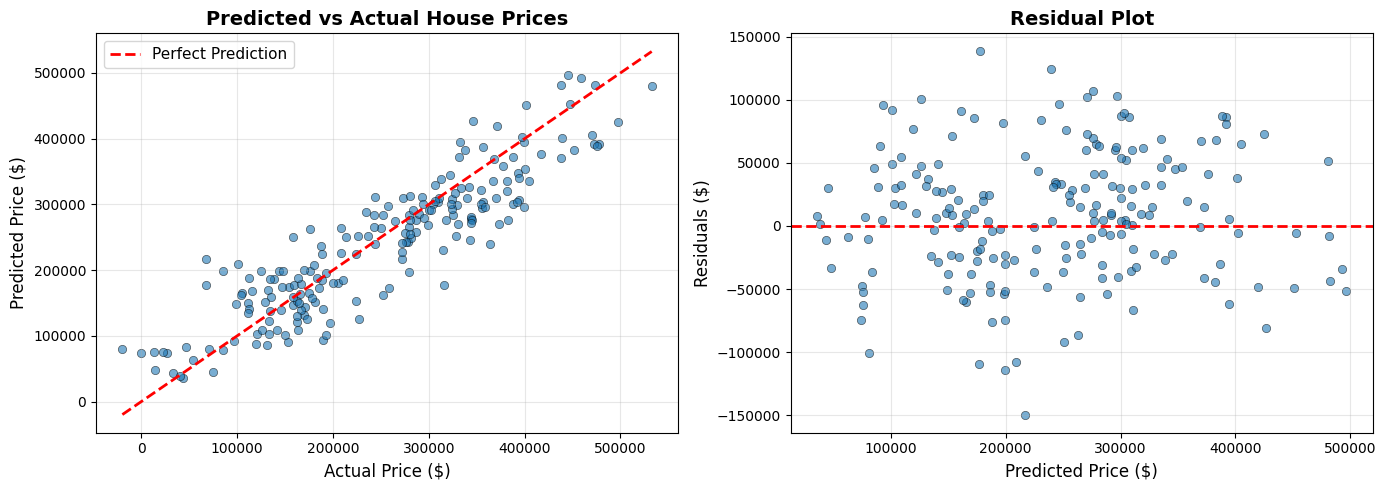

In [64]:
plt.figure(figsize=(14, 5))

# Scatter plot: Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y_test_original, y_pred_original, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title('Predicted vs Actual House Prices', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Residual plot
residuals = y_test_original - y_pred_original
plt.subplot(1, 2, 2)
plt.scatter(y_pred_original, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Sample Predictions

Let's look at some individual predictions to see how well our model performs.


In [65]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Size (sq ft)': X_test[:, 0],
    'Bedrooms': X_test[:, 1],
    'Age (years)': X_test[:, 2],
    'Actual Price ($)': y_test_original.flatten(),
    'Predicted Price ($)': y_pred_original.flatten(),
})

comparison_df['Error ($)'] = comparison_df['Actual Price ($)'] - comparison_df['Predicted Price ($)']
comparison_df['Error (%)'] = (comparison_df['Error ($)'] / comparison_df['Actual Price ($)']) * 100

# Display first 15 predictions
print("\nSample Predictions:")
print("="*100)
print(comparison_df.head(15).to_string(index=False))
print("="*100)



Sample Predictions:
 Size (sq ft)  Bedrooms  Age (years)  Actual Price ($)  Predicted Price ($)      Error ($)   Error (%)
  2018.850741       2.0    13.891104      67655.298609        217168.562500 -149513.263891 -220.992689
  3413.118206       2.0    26.361309     333232.083746        324480.312500    8751.771246    2.626329
  2280.575314       5.0    40.989890     343211.157124        246308.437500   96902.719624   28.234140
  1939.509523       5.0    41.927461     272007.927829        216834.687500   55173.240329   20.283688
  3840.198295       4.0    19.487969     497897.821990        425074.562500   72823.259490   14.626145
  3902.305386       4.0    15.024469     447286.212369        452524.187500   -5237.975131   -1.171057
  2280.111092       3.0     5.262959     382776.931910        275964.093750  106812.838160   27.904722
  3571.404446       1.0    41.665854     387504.608544        300191.656250   87312.952294   22.532107
  1010.267646       3.0    31.716987     131377.6381

---

# Summary and Conclusion

## What We Learned

In this notebook, we built a complete house price prediction neural network from the ground up. Let's recap the key mathematical concepts:

### 1. Data Normalization
$$
x_{\text{norm}} = \frac{x - \mu}{\sigma}
$$
Normalized our features to have zero mean and unit variance, enabling faster convergence.

### 2. Forward Propagation
Our network computes predictions through a series of transformations:

$$
\begin{align}
z^{[1]} &= W^{[1]} x + b^{[1]} \\
a^{[1]} &= \text{ReLU}(z^{[1]}) \\
z^{[2]} &= W^{[2]} a^{[1]} + b^{[2]} \\
a^{[2]} &= \text{ReLU}(z^{[2]}) \\
\hat{y} &= W^{[3]} a^{[2]} + b^{[3]}
\end{align}
$$

### 3. Loss Function
Mean Squared Error measures how far predictions are from the truth:

$$
\mathcal{L} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

### 4. Backpropagation
Using the chain rule, we compute how each parameter affects the loss:

$$
\frac{\partial \mathcal{L}}{\partial W} = \frac{\partial \mathcal{L}}{\partial z} \cdot \frac{\partial z}{\partial W}
$$

The gradient flows backward through the network, layer by layer.

### 5. Gradient Descent
Parameters are updated to minimize loss:

$$
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
$$

## Why Neural Networks Work

Neural networks are **universal function approximators**. By stacking linear transformations with non-linear activations, they can learn arbitrarily complex patterns in data. The backpropagation algorithm efficiently computes gradients for millions of parameters, enabling the network to learn from data.

## Key Takeaways

1. **Normalization is crucial** - It stabilizes training and improves convergence
2. **Non-linearity is essential** - ReLU activations enable learning complex patterns
3. **Backpropagation is automatic** - PyTorch's autograd computes gradients for us
4. **Validation prevents overfitting** - Monitor validation loss to ensure generalization
5. **Mathematics powers AI** - Calculus and linear algebra are the foundation

## Next Steps

To improve this model, you could:
- Add more features (location, square footage, amenities)
- Experiment with different architectures (more/fewer layers, different sizes)
- Try different activation functions (LeakyReLU, ELU, Swish)
- Implement regularization (L2, Dropout)
- Use learning rate scheduling
- Perform hyperparameter tuning

---

**Congratulations!** You now understand the mathematical foundations of neural networks and can implement them in PyTorch.
